# **Import Libraries**

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import os
import PIL
import skimage
from skimage import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from torch.utils.data import DataLoader
from tqdm import tqdm
seed = 123
import cv2
import xml.etree.ElementTree as ET
torch.manual_seed(seed)
from collections import Counter

# Link to the original paper
[https://pjreddie.com/media/files/papers/yolo_1.pdf](http://)

# **Model Architecture**

In [2]:
architecture_config = [
    #Tuple: (kernel_size, number of filters, strides, padding)
    (7, 64, 2, 3),
    #"M" = Max Pool Layer
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    #List: [(tuple), (tuple), how many times to repeat]
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
    #Doesnt include fc layers
]



In [3]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))


class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        # In original paper this should be
        # nn.Linear(1024*S*S, 4096),
        # nn.LeakyReLU(0.1),
        # nn.Linear(4096, S*S*(B*5+C))
        #Original paper uses nn.Linear(1024 * S * S, 4096) not 496. 
        # Also the last layer will be reshaped to (S, S, 13) where C+B*5 = 13
        
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
        )


# **Testing with tensor**

In [4]:
def test(S=7, B=2, C=20):
    model = Yolov1(split_size=S, num_boxes=B, num_classes=C)
    x = torch.randn((2,3,448,448))
    print(model(x).shape)

test() 
    

torch.Size([2, 1470])


# **Utility Functions**

# **Intersection Over Union**

In [5]:
def intersection_over_union(boxes_preds, boxes_labels, box_format='midpoint'):
    """
    Calculates intersection over union
    
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes are (x,y,w,h) or (x1,y1,x2,y2) respectively.
    
    Returns:
        tensor: Intersection over union for all examples
    """
    # boxes_preds shape is (N, 4) where N is the number of bboxes
    #boxes_labels shape is (n, 4)
    
    if box_format == 'midpoint':
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
        
    if box_format == 'corners':
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4] # Output tensor should be (N, 1). If we only use 3, we go to (N)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]
    
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)
    
    #.clamp(0) is for the case when they don't intersect. Since when they don't intersect, one of these will be negative so that should become 0
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
    
    return intersection / (box1_area + box2_area - intersection + 1e-6)

# **Non-Max Supression**

In [6]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

# **Mean Average Precision**

In [7]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculates mean average precision 
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [8]:
def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle potch
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()


# **Last Utility Functions**

In [9]:
def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes



def convert_cellboxes(predictions, S=7, C=20):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, C + 10)
    bboxes1 = predictions[..., C + 1:C + 5]
    bboxes2 = predictions[..., C + 6:C + 10]
    scores = torch.cat(
        (predictions[..., C].unsqueeze(0), predictions[..., C + 5].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :C].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., C], predictions[..., C + 5]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

def save_checkpoint(state, filename="my_checkpoint.pth"):
    print("=> Saving checkpoint")
    torch.save(state, filename)
    
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dic"])
    optimizer.load_state_dict(checkpoint["optimizer"])

# **Dataset Preprocessing**

In [10]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(
        self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform=None,
    ):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n", "").split()
                ]

                boxes.append([class_label, x, y, width, height])

        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        boxes = torch.tensor(boxes)

        if self.transform:
            # image = self.transform(image)
            image, boxes = self.transform(image, boxes)

        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 5*self.B )) #changed 5*self.B
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            # i,j represents the cell row and cell column
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            """
            Calculating the width and height of cell of bounding box,
            relative to the cell is done by the following, with
            width as the example:
            
            width_pixels = (width*self.image_width)
            cell_pixels = (self.image_width)
            
            Then to find the width relative to the cell is simply:
            width_pixels/cell_pixels, simplification leads to the
            formulas below.
            """
            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            # If no object already found for specific cell i,j
            # Note: This means we restrict to ONE object
            # per cell!
            if label_matrix[i, j, 20] == 0:
                # Set that there exists an object
                label_matrix[i, j, 20] = 1

                # Box coordinates
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, 21:25] = box_coordinates

                # Set one hot encoding for class_label
                label_matrix[i, j, class_label] = 1

        return image, label_matrix


# **Model Loss**

In [11]:
"""
Implementation of Yolo Loss Function from the original yolo paper

"""
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper and VOC dataset is 20),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*5) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30]
                + (1 - bestbox) * predictions[..., 21:25]
            )
        )

        box_targets = exists_box * target[..., 21:25]

        # Take sqrt of width, height of boxes to ensure that
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        #max_no_obj = torch.max(predictions[..., 20:21], predictions[..., 25:26])
        #no_object_loss = self.mse(
        #    torch.flatten((1 - exists_box) * max_no_obj, start_dim=1),
        #    torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        #)

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss


# **Model Training loop implementation**

In [13]:
# Hyperparameters etc. 
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 16 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0
EPOCHS = 20
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "overfit.pth.tar"
IMG_DIR = "/kaggle/input/pascalvoc-yolo/images"
LABEL_DIR = "/kaggle/input/pascalvoc-yolo/labels"


In [14]:
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")


In [15]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])

In [37]:
def main():
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    train_dataset = VOCDataset(
        "/kaggle/input/pascalvoc-yolo/train.csv",
        transform=transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
    )

    test_dataset = VOCDataset(
        "/kaggle/input/pascalvoc-yolo/test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    for epoch in range(EPOCHS):
        # for x, y in train_loader:
        #    x = x.to(DEVICE)
        #    for idx in range(8):
        #        bboxes = cellboxes_to_boxes(model(x))
        #        bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        #        plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

        #    import sys
        #    sys.exit()

        pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.4
        )

        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        print(f"Train mAP: {mean_avg_prec}")

        #if mean_avg_prec > 0.9:
        #    checkpoint = {
        #        "state_dict": model.state_dict(),
        #        "optimizer": optimizer.state_dict(),
        #    }
        #    save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
        #    import time
        #    time.sleep(10)

        train_fn(train_loader, model, optimizer, loss_fn)


if __name__ == "__main__":
    main()

  0%|          | 0/1034 [00:00<?, ?it/s]

Train mAP: 0.0


  4%|▍         | 46/1034 [00:16<06:01,  2.73it/s, loss=485]   
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

Epoch [1/20]: 100%|██████████| 1034/1034 [06:03<00:00,  2.84it/s, loss=160]  


Epoch [1/20], Loss: 217.3836, Train mAP: 0.0050


Epoch [2/20]: 100%|██████████| 1034/1034 [06:02<00:00,  2.85it/s, loss=148]


Epoch [2/20], Loss: 165.3884, Train mAP: 0.0073


Epoch [3/20]: 100%|██████████| 1034/1034 [06:02<00:00,  2.85it/s, loss=91.8]


Epoch [3/20], Loss: 157.1068, Train mAP: 0.0072


Epoch [4/20]: 100%|██████████| 1034/1034 [06:02<00:00,  2.85it/s, loss=144] 


Epoch [4/20], Loss: 148.8826, Train mAP: 0.0158


Epoch [5/20]: 100%|██████████| 1034/1034 [06:02<00:00,  2.86it/s, loss=194] 


Epoch [5/20], Loss: 137.7236, Train mAP: 0.0209


Epoch [6/20]: 100%|██████████| 1034/1034 [06:02<00:00,  2.85it/s, loss=137] 


Epoch [6/20], Loss: 129.8388, Train mAP: 0.0120


Epoch [7/20]: 100%|██████████| 1034/1034 [06:02<00:00,  2.85it/s, loss=92.6]


Epoch [7/20], Loss: 123.7894, Train mAP: 0.0177


Epoch [8/20]: 100%|██████████| 1034/1034 [06:02<00:00,  2.85it/s, loss=133] 


Epoch [8/20], Loss: 117.3609, Train mAP: 0.0215


Epoch [9/20]: 100%|██████████| 1034/1034 [06:02<00:00,  2.85it/s, loss=73.1]


Epoch [9/20], Loss: 109.0979, Train mAP: 0.0390


Epoch [10/20]: 100%|██████████| 1034/1034 [06:01<00:00,  2.86it/s, loss=84.9]


Epoch [10/20], Loss: 99.4813, Train mAP: 0.0402


Epoch [11/20]: 100%|██████████| 1034/1034 [06:02<00:00,  2.85it/s, loss=127] 


Epoch [11/20], Loss: 90.1333, Train mAP: 0.0622


Epoch [12/20]: 100%|██████████| 1034/1034 [06:02<00:00,  2.85it/s, loss=75.5]


Epoch [12/20], Loss: 80.7313, Train mAP: 0.0646


Epoch [13/20]: 100%|██████████| 1034/1034 [06:02<00:00,  2.85it/s, loss=71.4]


Epoch [13/20], Loss: 72.8233, Train mAP: 0.0768


Epoch [14/20]: 100%|██████████| 1034/1034 [06:02<00:00,  2.85it/s, loss=77.5]


Epoch [14/20], Loss: 64.7330, Train mAP: 0.1681


Epoch [15/20]: 100%|██████████| 1034/1034 [06:02<00:00,  2.85it/s, loss=32.1]


Epoch [15/20], Loss: 58.9973, Train mAP: 0.1836


Epoch [16/20]: 100%|██████████| 1034/1034 [06:02<00:00,  2.85it/s, loss=59.2]


Epoch [16/20], Loss: 53.9584, Train mAP: 0.3042


Epoch [17/20]: 100%|██████████| 1034/1034 [06:02<00:00,  2.85it/s, loss=63.1]


Epoch [17/20], Loss: 49.5319, Train mAP: 0.3129


Epoch [18/20]: 100%|██████████| 1034/1034 [06:02<00:00,  2.85it/s, loss=34.3]


Epoch [18/20], Loss: 46.2533, Train mAP: 0.4029


Epoch [19/20]: 100%|██████████| 1034/1034 [06:02<00:00,  2.85it/s, loss=35.4]


Epoch [19/20], Loss: 42.2980, Train mAP: 0.4269


Epoch [20/20]: 100%|██████████| 1034/1034 [06:02<00:00,  2.85it/s, loss=32.8]


Epoch [20/20], Loss: 40.0488, Train mAP: 0.4273


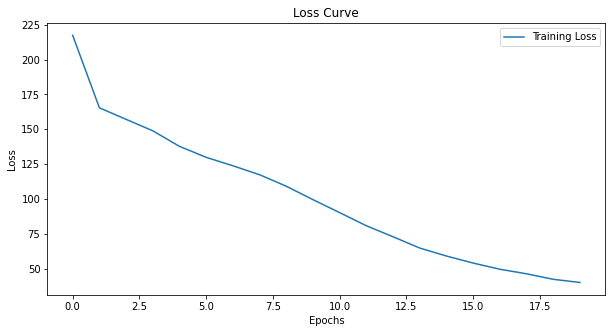

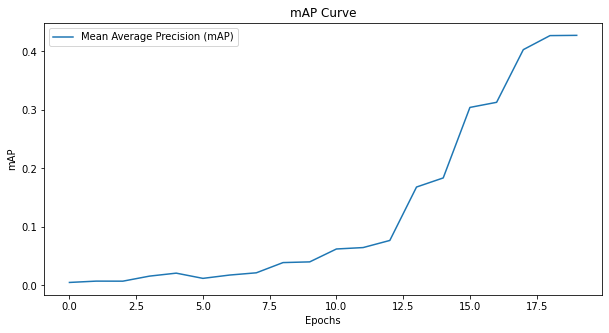

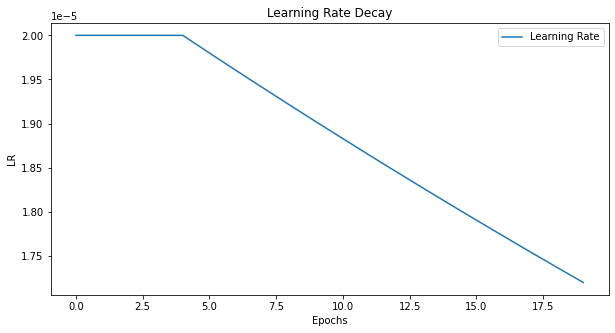

In [14]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter  # TensorBoard
import seaborn as sns
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Initialize TensorBoard
writer = SummaryWriter("runs/yolo_training")

def plot_grad_flow(named_parameters, epoch):
    """Plots the gradient flow of model parameters"""
    ave_grads = []
    layers = []
    
    for n, p in named_parameters:
        if p.requires_grad and p.grad is not None:
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu().item())

    plt.figure(figsize=(10, 5))
    plt.plot(layers, ave_grads, "b", marker="o", markersize=5, label="Average Gradient")
    plt.xticks(rotation=90)
    plt.xlabel("Layers")
    plt.ylabel("Gradient Magnitude")
    plt.title(f"Gradient Flow at Epoch {epoch}")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"gradient_flow_epoch_{epoch}.png")
    plt.close()

def plot_image_predictions(images, predictions, epoch):
    """Plots sample images with predicted bounding boxes"""
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))

    for i, ax in enumerate(axes):
        img = images[i].permute(1, 2, 0).cpu().numpy()
        ax.imshow(img)

        for bbox in predictions[i]:  # Loop over predicted boxes
            class_idx, conf, x, y, w, h = bbox
            if conf > 0.5:
                rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor="r", linewidth=2)
                ax.add_patch(rect)
                ax.text(x, y, f"Class {int(class_idx)}: {conf:.2f}", color="white", 
                        fontsize=8, bbox=dict(facecolor="red", alpha=0.5))

    plt.suptitle(f"Bounding Box Predictions at Epoch {epoch}")
    plt.savefig(f"predictions_epoch_{epoch}.png")
    plt.close()

def main():
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    train_dataset = VOCDataset(
        "/kaggle/input/pascalvoc-yolo/train.csv",
        transform=transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
    )

    test_dataset = VOCDataset(
        "/kaggle/input/pascalvoc-yolo/test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    losses, mAPs, lrs = [], [], []

    for epoch in range(EPOCHS):
        model.train()
        loop = tqdm(train_loader, leave=True)
        total_loss = 0

        for batch_idx, (images, targets) in enumerate(loop):
            images, targets = images.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            predictions = model(images)
            loss = loss_fn(predictions, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}]")
            loop.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)

        writer.add_scalar("Loss/train", avg_loss, epoch)

        # Get model predictions for evaluation
        pred_boxes, target_boxes = get_bboxes(train_loader, model, iou_threshold=0.5, threshold=0.4)
        mean_avg_prec = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
        mAPs.append(mean_avg_prec)

        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}, Train mAP: {mean_avg_prec:.4f}")

        writer.add_scalar("mAP/train", mean_avg_prec, epoch)
        writer.add_scalar("Learning Rate", optimizer.param_groups[0]["lr"], epoch)

        # Save Gradient Flow
        plot_grad_flow(model.named_parameters(), epoch)

        # Save Sample Predictions
        if epoch % 5 == 0:  # Every 5 epochs
            sample_images, _ = next(iter(train_loader))
            sample_images = sample_images[:5].to(DEVICE)  # Take 5 images
            sample_preds = model(sample_images).cpu().detach()
            bboxes = cellboxes_to_boxes(sample_preds)
            plot_image_predictions(sample_images, bboxes, epoch)

        # Reduce Learning Rate if needed
        if epoch > 4:
            for param_group in optimizer.param_groups:
                param_group["lr"] *= 0.99  # Decay by 1% every epoch after 10

        lrs.append(optimizer.param_groups[0]["lr"])

    # Final Loss & mAP Graph
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.savefig("loss_curve.png")

    plt.figure(figsize=(10, 5))
    plt.plot(mAPs, label="Mean Average Precision (mAP)")
    plt.xlabel("Epochs")
    plt.ylabel("mAP")
    plt.title("mAP Curve")
    plt.legend()
    plt.savefig("mAP_curve.png")

    plt.figure(figsize=(10, 5))
    plt.plot(lrs, label="Learning Rate")
    plt.xlabel("Epochs")
    plt.ylabel("LR")
    plt.title("Learning Rate Decay")
    plt.legend()
    plt.savefig("learning_rate_curve.png")

    writer.close()

if __name__ == "__main__":
    main()


# **Predictions**

In [12]:
model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to("cpu")
model.load_state_dict(torch.load("/kaggle/working/yolo_model.pth", map_location="cpu"))
model.eval()
print("Model loaded successfully!")

Model loaded successfully!


In [13]:
!pip3 install torchinfo
from torchinfo import summary
summary(model) 


Layer (type:depth-idx)                   Param #
Yolov1                                   --
├─Sequential: 1-1                        --
│    └─CNNBlock: 2-1                     --
│    │    └─Conv2d: 3-1                  9,408
│    │    └─BatchNorm2d: 3-2             128
│    │    └─LeakyReLU: 3-3               --
│    └─MaxPool2d: 2-2                    --
│    └─CNNBlock: 2-3                     --
│    │    └─Conv2d: 3-4                  110,592
│    │    └─BatchNorm2d: 3-5             384
│    │    └─LeakyReLU: 3-6               --
│    └─MaxPool2d: 2-4                    --
│    └─CNNBlock: 2-5                     --
│    │    └─Conv2d: 3-7                  24,576
│    │    └─BatchNorm2d: 3-8             256
│    │    └─LeakyReLU: 3-9               --
│    └─CNNBlock: 2-6                     --
│    │    └─Conv2d: 3-10                 294,912
│    │    └─BatchNorm2d: 3-11            512
│    │    └─LeakyReLU: 3-12              --
│    └─CNNBlock: 2-7                     --
│    │

In [14]:
import time

# Configure transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
])

CLASSES = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 
    'bus', 'car', 'cat', 'chair', 'cow', 
    'diningtable', 'dog', 'horse', 'motorbike', 'person', 
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

CONFIDENCE_THRESHOLD = 0.67
def predict(image):
    """Runs YOLO model on input frame"""
    orig_height, orig_width = image.shape[:2]  # Get original frame size
    
    # Transform input image (resize & normalize)
    img_tensor = transform(image).unsqueeze(0)  # Convert to tensor
    
    # Run YOLO model
    start_time = time.time()
    with torch.no_grad():
        output = model(img_tensor)
    inference_time = time.time() - start_time
    
    # Convert model output to bounding boxes
    bboxes = cellboxes_to_boxes(output)
    results = []

    for box in bboxes[0]:
        class_idx, conf, x, y, w, h = box  # YOLO outputs (normalized)

        if conf > CONFIDENCE_THRESHOLD:
            # Convert to top-left corner format
            x_min = int((x - w / 2) * orig_width)  # Scale to image size
            y_min = int((y - h / 2) * orig_height)
            w_scaled = int(w * orig_width)
            h_scaled = int(h * orig_height)

            # Ensure bounding box is within valid image dimensions
            x_min = max(0, min(x_min, orig_width - 1))
            y_min = max(0, min(y_min, orig_height - 1))
            w_scaled = max(1, min(w_scaled, orig_width - x_min))
            h_scaled = max(1, min(h_scaled, orig_height - y_min))

            # Get class name
            class_name = CLASSES[int(class_idx)] if int(class_idx) < len(CLASSES) else f"class_{int(class_idx)}"

            results.append({
                "class": class_name,
                "class_id": int(class_idx),
                "conf": float(conf),
                "x": x_min,
                "y": y_min,
                "w": w_scaled,
                "h": h_scaled
            })

    print(f"Inference time: {inference_time:.3f}s, Found {len(results)} objects with conf > {CONFIDENCE_THRESHOLD}")
    if results:
        print(f"Top detection: {results[0]['class']} with confidence {results[0]['conf']:.2f}")

    return results, inference_time


Inference time: 0.378s, Found 1 objects with conf > 0.67
Top detection: train with confidence 0.78


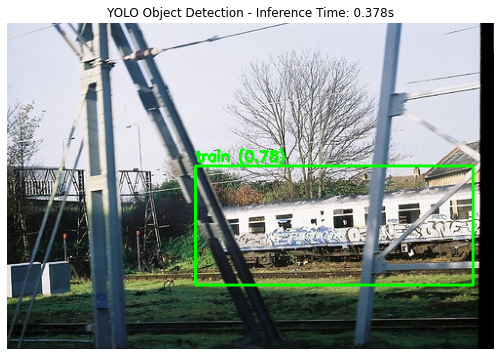

In [43]:
import cv2
import torch
import matplotlib.pyplot as plt

def draw_bounding_boxes(image, results):
    """Draw bounding boxes and labels on the image"""
    for det in results:
        x, y, w, h = det["x"], det["y"], det["w"], det["h"]
        class_name = det["class"]
        conf = det["conf"]

        # Draw bounding box
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        # Display label
        cv2.putText(image, f"{class_name} ({conf:.2f})", (x, y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    return image

# Load test image
image_path = "/kaggle/input/pascalvoc-yolo/images/000024.jpg"  
image = cv2.imread(image_path)

if image is None:
    print("Error: Could not load image!")
else:
    results, inference_time = predict(image)
    
    image_with_boxes = draw_bounding_boxes(image, results)

    image_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 6))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title(f"YOLO Object Detection - Inference Time: {inference_time:.3f}s")
    plt.show()


Inference time: 0.307s, Found 1 objects with conf > 0.67
Top detection: car with confidence 0.89


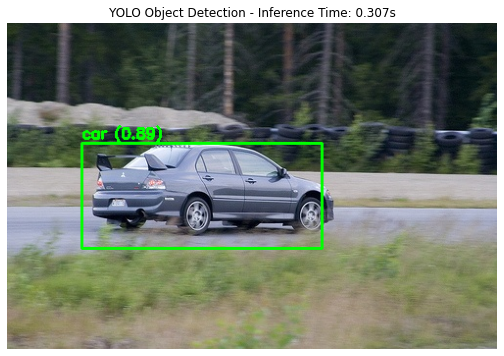

In [15]:
import cv2
import torch
import matplotlib.pyplot as plt

def draw_bounding_boxes(image, results):
    """Draw bounding boxes and labels on the image"""
    for det in results:
        x, y, w, h = det["x"], det["y"], det["w"], det["h"]
        class_name = det["class"]
        conf = det["conf"]

        # Draw bounding box
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        # Display label
        cv2.putText(image, f"{class_name} ({conf:.2f})", (x, y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    return image

# Load test image
image_path = "/kaggle/input/pascalvoc-yolo/images/000026.jpg"  
image = cv2.imread(image_path)

if image is None:
    print("Error: Could not load image!")
else:
    results, inference_time = predict(image)
    
    image_with_boxes = draw_bounding_boxes(image, results)

    image_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 6))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title(f"YOLO Object Detection - Inference Time: {inference_time:.3f}s")
    plt.show()

Inference time: 0.267s, Found 2 objects with conf > 0.67
Top detection: person with confidence 0.73


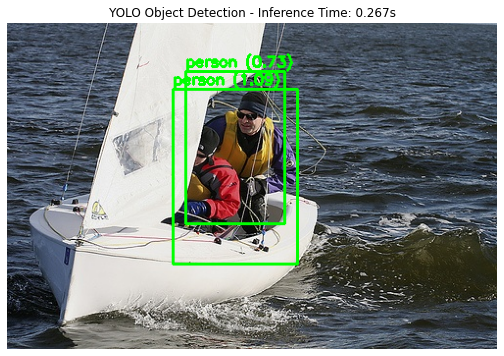

In [16]:
def draw_bounding_boxes(image, results):
    """Draw bounding boxes and labels on the image"""
    for det in results:
        x, y, w, h = det["x"], det["y"], det["w"], det["h"]
        class_name = det["class"]
        conf = det["conf"]

        # Draw bounding box
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        # Display label
        cv2.putText(image, f"{class_name} ({conf:.2f})", (x, y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    return image

# Load test image
image_path = "/kaggle/input/pascalvoc-yolo/images/000105.jpg"  
image = cv2.imread(image_path)

if image is None:
    print("Error: Could not load image!")
else:
    results, inference_time = predict(image)
    
    image_with_boxes = draw_bounding_boxes(image, results)

    image_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 6))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title(f"YOLO Object Detection - Inference Time: {inference_time:.3f}s")
    plt.show()